# Homework 6 - Generative Adversarial Network
This is the sample code for hw6 of 2022 Machine Learning course in National Taiwan University. 

In this sample code, there are 5 sections:
1. Environment setting
2. Dataset preparation
3. Model setting
4. Train
5. Inference

Your goal is to do anime face generation, if you have any question, please discuss at NTU COOL 

## ref
* https://github.com/pai4451/ML2021/tree/main/hw5
* https://github.com/Joshuaoneheart/ML2022_all_A_plus

## Environment setting
In this section, we will prepare for the dataset and set some environment variable

In [ ]:
!nvidia-smi

### Download Dataset

In [ ]:
%%script false --no-raise-error

# colab
# get dataset from huggingface hub
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
!apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
!unzip ./MLHW_6/faces.zip -d .

In [ ]:
# colab
# data_dir = "."
# workspace_dir = '.'

# kaggle
data_dir = "../input/ml2022hw06"
workspace_dir = '.'

### Other setting

In [ ]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm


# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(3)

## CUDA Environments

In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if cuda else 'cpu')
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device

## Dataset preparation
In this section, we prepare for the dataset for Pytorch

### Create dataset for Pytorch

In order to unified image information, we use the transform function to:
1. Resize image to 64x64
2. Normalize the image

This CrypkoDataset class will be use in Section 4

In [ ]:
# prepare for CrypkoDataset

class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(), # range [0, 255] -> [0.0, 1.0]
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), # range [0, 1.0] -> [-1.0, 1.0]
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show the image
Show some sample in the dataset

In [ ]:
temp_dataset = get_dataset(os.path.join(data_dir, 'faces'))

images = [temp_dataset[i] for i in range(10*10)]
grid_img = torchvision.utils.make_grid(images, ncol=10, nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model setting
In this section, we will create models and trainer.

### Create model
In this section, we will create models for Generator and Discriminator

In [ ]:
# Generator

class Generator(nn.Module):
    """
    Input shape: (batch, in_dim)
    Output shape: (batch, 3, 64, 64)
    """
    def __init__(self, in_dim, feature_dim=64):
        super().__init__()
    
        #input: (batch, 100)
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, feature_dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            self.dconv_bn_relu(feature_dim * 8, feature_dim * 4),               #(batch, feature_dim * 16, 8, 8)     
            self.dconv_bn_relu(feature_dim * 4, feature_dim * 2),               #(batch, feature_dim * 16, 16, 16)     
            self.dconv_bn_relu(feature_dim * 2, feature_dim),                   #(batch, feature_dim * 16, 32, 32)     
        )
        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 3, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),
            nn.Tanh()   
        )
        self.apply(weights_init)
    def dconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),        #double height and width
            nn.BatchNorm2d(out_dim),
            nn.ReLU(True)
        )
    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2(y)
        y = self.l3(y)
        return y

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    """
    Input shape: (batch, 3, 64, 64)
    Output shape: (batch)
    """
    def __init__(self, in_dim, feature_dim=64):
        super(Discriminator, self).__init__()
            
        #input: (batch, 3, 64, 64)
        """
        NOTE FOR SETTING DISCRIMINATOR:

        Remove last sigmoid layer for WGAN
        """
        self.l1 = nn.Sequential(
            nn.Conv2d(in_dim, feature_dim, kernel_size=4, stride=2, padding=1), #(batch, 3, 32, 32)
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim * 2),                   #(batch, 3, 16, 16)
            self.conv_bn_lrelu(feature_dim * 2, feature_dim * 4),               #(batch, 3, 8, 8)
            self.conv_bn_lrelu(feature_dim * 4, feature_dim * 8),               #(batch, 3, 4, 4)
            nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0),
            # for DCGAN
            # nn.Sigmoid() 
        )
        self.apply(weights_init)
    def conv_bn_lrelu(self, in_dim, out_dim):
        """
        NOTE FOR SETTING DISCRIMINATOR:

        You can't use nn.Batchnorm for WGAN-GP
        Use nn.InstanceNorm2d instead
        """

        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(out_dim), # WGAN/DCGAN
            nn.InstanceNorm2d(out_dim), # WGAN-GP
            nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        y = self.l1(x)
        y = y.view(-1)
        return y

In [ ]:
# setting for weight init function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Create trainer
In this section, we will create a trainer which contains following functions:
1. prepare_environment: prepare the overall environment, construct the models, create directory for the log and ckpt
2. train: train for generator and discriminator, you can try to modify the code here to construct WGAN or WGAN-GP
3. inference: after training, you can pass the generator ckpt path into it and the function will save the result for you

WGAN/WGAN-GP: https://towardsdatascience.com/demystified-wasserstein-gans-wgan-f835324899f4

In [ ]:
class TrainerGAN():
    def __init__(self, config):
        self.config = config
        
        self.G = Generator(100)
        self.D = Discriminator(3)
        
        # DCGAN
        self.loss = nn.BCELoss()

        """
        NOTE FOR SETTING OPTIMIZER:

        GAN: use Adam optimizer
        WGAN: use RMSprop optimizer
        WGAN-GP: use Adam optimizer 
        """
        # ===================================================
        # DCGAN/WGAN-GP
        self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        # WGAN
        # self.opt_D = torch.optim.RMSprop(self.D.parameters(), lr=self.config["lr"], alpha=0.99)
        # self.opt_G = torch.optim.RMSprop(self.G.parameters(), lr=self.config["lr"], alpha=0.99)
        # ===================================================
        
        self.dataloader = None
        self.log_dir = os.path.join(self.config["workspace_dir"], 'logs')
        self.ckpt_dir = os.path.join(self.config["workspace_dir"], 'checkpoints')
        
        FORMAT = '%(asctime)s - %(levelname)s: %(message)s'
        logging.basicConfig(level=logging.INFO, 
                            format=FORMAT,
                            datefmt='%Y-%m-%d %H:%M')
        
        self.steps = 0
        self.z_samples = Variable(torch.randn(100, self.config["z_dim"])).to(self.config["device"])
        
    def prepare_environment(self):
        """
        Use this funciton to prepare function
        """
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.ckpt_dir, exist_ok=True)
        
        # update dir by time
        time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        self.log_dir = os.path.join(self.log_dir, time+f'_{self.config["model_type"]}')
        self.ckpt_dir = os.path.join(self.ckpt_dir, time+f'_{self.config["model_type"]}')
        os.makedirs(self.log_dir)
        os.makedirs(self.ckpt_dir)
        
        # create dataset by the above function
        dataset = get_dataset(os.path.join(self.config["data_dir"], 'faces'))
        self.dataloader = DataLoader(dataset, batch_size=self.config["batch_size"], shuffle=True, num_workers=2)
        
        # model preparation
        self.G = self.G.to(self.config["device"])
        self.D = self.D.to(self.config["device"])
        self.G.train()
        self.D.train()
        
    def gp(self, real_samples, fake_samples):
        """
        Implement gradient penalty function
        """
        batch_size = real_samples.size(0)
        
        # Random weight term for interpolation between real and fake samples
        alpha = torch.rand(batch_size, 1, 1, 1).to(real_samples.device)
        alpha = alpha.expand_as(real_samples)
        
        # Get random interpolation between real and fake samples
        interpolates = alpha * real_samples + (1 - alpha) * fake_samples
        
        # get logits for interpolated images
        interp_logits  = self.D(interpolates)
        grad_outputs = torch.ones_like(interp_logits)
        
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=interp_logits ,
            inputs=interpolates,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
        )[0]
        
        # Compute and return Gradient Norm
        gradients = gradients.view(batch_size, -1)
        grad_norm = gradients.norm(2, dim=1)
        gradient_penalty = torch.mean((grad_norm - 1) ** 2)
        
        return gradient_penalty
        
    def train(self):
        """
        Use this function to train generator and discriminator
        """
        self.prepare_environment()
        
        for e, epoch in enumerate(range(self.config["n_epoch"])):
            progress_bar = tqdm(self.dataloader)
            progress_bar.set_description(f"Epoch {e+1}")
            for i, data in enumerate(progress_bar):
                imgs = data.to(self.config["device"])
                bs = imgs.size(0)

                # *********************
                # *    Train D        *
                # *********************
                z = Variable(torch.randn(bs, self.config["z_dim"])).to(self.config["device"])
                r_imgs = Variable(imgs).to(self.config["device"])
                f_imgs = self.G(z)
                r_label = torch.ones((bs)).to(self.config["device"])
                f_label = torch.zeros((bs)).to(self.config["device"])


                # Discriminator forwarding
                r_logit = self.D(r_imgs)
                f_logit = self.D(f_imgs)

                """
                NOTE FOR SETTING DISCRIMINATOR LOSS:
                
                GAN: 
                    loss_D = (r_loss + f_loss)/2
                WGAN: 
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                WGAN-GP: 
                    gradient_penalty = self.gp(r_imgs, f_imgs)
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
                """
                # Loss for discriminator
                # ======================================================
                # DCGAN
                # r_loss = self.loss(r_logit, r_label)
                # f_loss = self.loss(f_logit, f_label)
                # loss_D = (r_loss + f_loss) / 2
                
                # WGAN
                # loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                
                # WGAN-GP
                gradient_penalty = self.gp(r_imgs, f_imgs)
                loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + self.config["lambda_gp"] * gradient_penalty
                # ======================================================
                
                # Discriminator backwarding
                self.D.zero_grad()
                loss_D.backward()
                self.opt_D.step()

                """
                NOTE FOR SETTING WEIGHT CLIP:
                
                WGAN: below code
                """
#                 for p in self.D.parameters():
#                     p.data.clamp_(-self.config["clip_value"], self.config["clip_value"])



                # *********************
                # *    Train G        *
                # *********************
                if self.steps % self.config["n_critic"] == 0:
                    # Generate some fake images.
                    z = Variable(torch.randn(bs, self.config["z_dim"])).to(self.config["device"])
                    f_imgs = self.G(z)

                    # Generator forwarding
                    f_logit = self.D(f_imgs)


                    """
                    NOTE FOR SETTING LOSS FOR GENERATOR:
                    
                    GAN: loss_G = self.loss(f_logit, r_label)
                    WGAN: loss_G = -torch.mean(self.D(f_imgs))
                    WGAN-GP: loss_G = -torch.mean(self.D(f_imgs))
                    """
                    # Loss for the generator.
                    # ======================================================
                    # DCGAN
                    # loss_G = self.loss(f_logit, r_label)
                    
                    # WGAN/WGAN-GP
                    loss_G = -torch.mean(f_logit)
                    # ======================================================

                    # Generator backwarding
                    self.G.zero_grad()
                    loss_G.backward()
                    self.opt_G.step()
                    
                if self.steps % 10 == 0:
                    progress_bar.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())
                self.steps += 1

            self.G.eval()
            f_imgs_sample = (self.G(self.z_samples).data + 1) / 2.0 # range [-1.0, 1.0] -> [0.0, 1.0]
            filename = os.path.join(self.log_dir, f'Epoch_{epoch+1:03d}.jpg')
            torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
            logging.info(f'Save some samples to {filename}.')

            # Show some images during training.
            grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
            plt.figure(figsize=(10,10))
            plt.imshow(grid_img.permute(1, 2, 0)) # channels, w, h -> w, h, channels
            plt.show()

            self.G.train()

            if (e+1) % 5 == 0 or e == 0:
                # Save the checkpoints.
                torch.save(self.G.state_dict(), os.path.join(self.ckpt_dir, f'G_{e}.pth'))
                torch.save(self.D.state_dict(), os.path.join(self.ckpt_dir, f'D_{e}.pth'))

        logging.info('Finish training')

    def inference(self, G_path, n_generate=1000, n_output=30, show=False):
        """
        1. G_path is the path for Generator ckpt
        2. You can use this function to generate final answer
        """

        self.G.load_state_dict(torch.load(G_path))
        self.G.to(self.config["device"])
        self.G.eval()
        z = Variable(torch.randn(n_generate, self.config["z_dim"])).to(self.config["device"])
        imgs = (self.G(z).data + 1) / 2.0 # range [-1.0, 1.0] -> [0.0, 1.0]
        
        os.makedirs('output', exist_ok=True)
        for i in range(n_generate):
            torchvision.utils.save_image(imgs[i], f'output/{i+1}.jpg')
        
        if show:
            row, col = n_output//10 + 1, 10
            grid_img = torchvision.utils.make_grid(imgs[:n_output].cpu(), nrow=row)
            plt.figure(figsize=(row, col))
            plt.imshow(grid_img.permute(1, 2, 0)) # channels, w, h -> w, h, channels
            plt.show()

## Train
In this section, we will first set the config for trainer, then use it to train generator and discriminator

### Set config

In [ ]:
config = {
    "device": device,
    "model_type": "WGAN-GP",
    "batch_size": 64,
    "lr": 1e-4,
    "n_epoch": 100,
    "n_critic": 1,
    "z_dim": 100,
    "workspace_dir": workspace_dir, # define in the environment setting
    "data_dir": data_dir, # faces folder defined in the environment setting
    "clip_value": 1, # WGAN Clip the weights of the discriminator to a constant (1 ~ -1). 
    "lambda_gp": 10, # WGAN-GP
}

### Start to train

In [ ]:
# %%script false --no-raise-error

trainer = TrainerGAN(config)
trainer.train()

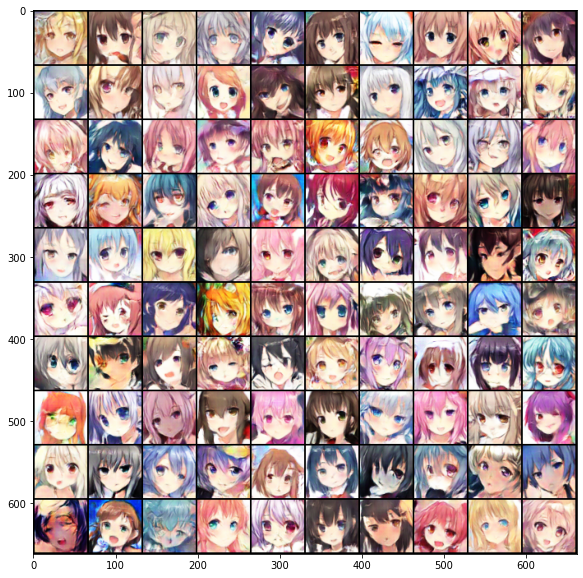

## Inference
In this section, we will use trainer to train model

### Inference through trainer

In [ ]:
%%script false --no-raise-error

# save the 1000 images into ./output folder
trainer.inference(f'{workspace_dir}/checkpoints/G_0.pth') # you have to modify the path when running this line

### Prepare .tar file for submission

In [ ]:
%%script false --no-raise-error

%cd output
!tar -zcf ../submission.tgz *.jpg
%cd ..

## Stylegan2
https://github.com/lucidrains/stylegan2-pytorch

In [ ]:
!pip install stylegan2_pytorch pytorch-fid

### Train

In [ ]:
%%script false --no-raise-error

!cp -rT ../input/hw06-stylegan2-tmp {workspace_dir}

!stylegan2_pytorch --data {data_dir}/faces \
                   --name stylegan2 \
                   --calculate-fid-every 5000 \
                   --models_dir {workspace_dir}/models \
                   --results_dir {workspace_dir}/results \
                   --image-size 64 \
                   --num-train-steps 100000

### Generate and show some images.

In [ ]:
# model_dir = workspace_dir
model_dir = "../input/hw06-stylegan2-tmp"

In [ ]:
# Generate 1000 images and make a grid to save them.
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = model_dir,   # path to where you invoked the command line tool
    name = 'stylegan2'                             # the project name, defaults to 'default'
)


n_output = 1000
noise   = torch.randn(n_output, 512) # noise
styles  = loader.noise_to_styles(noise, trunc_psi=0.75)  # pass through mapping network

# Show 32 of the images.
imgs_sample = loader.styles_to_images(styles[:100])
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), ncol=10, nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

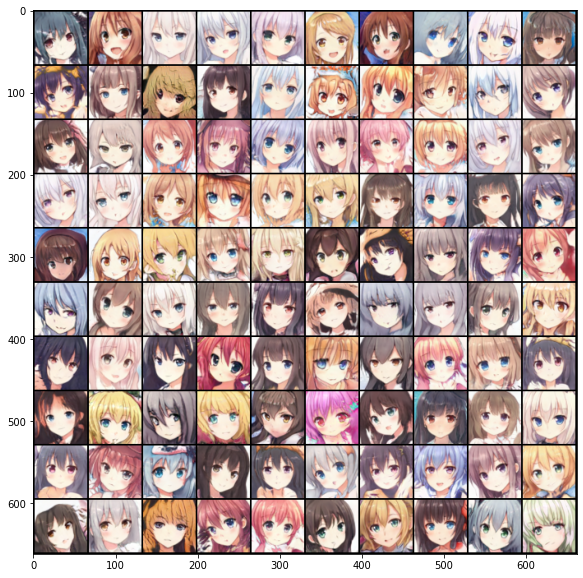

### Compress the generated images using **tar**.

In [ ]:
%%script false --no-raise-error

# Save the generated images.
os.makedirs(f'{workspace_dir}/output', exist_ok=True)
eval_batch_size = 100

for i in range(10):
    images = loader.styles_to_images(styles[i*eval_batch_size:(i+1)*eval_batch_size])
    for j in range(eval_batch_size):
        save_image(images[j], f'{workspace_dir}/output/{i*eval_batch_size+j+1}.jpg') # save your images, or do whatever you desire

%cd {workspace_dir}/output
!tar -zcf ../submission.tgz *.jpg
%cd ..

# or
# generate images from latest checkpoint
# !stylegan2_pytorch --name stylegan2 --generate --num_generate=1000 --image_size=64 --num_image_tiles 1

In [ ]:
# To generate a video of a interpolation through two random points in latent space.
!stylegan2_pytorch --name stylegan2 --generate-interpolation --interpolation-num-steps 100

## Report questions:
    
1. Describe the difference between WGAN* and GAN**, list at least two differences

2. Please plot the “Gradient norm” result.
    
    a. Use training dataset, set the number of discriminatorlayer to 4 (minimum requirement)
    
    b. Plot two setting:
    
       i. weight clipping
       ii. gradient penalty
    
    c. Y-axis: gradient norm(log scale), X-axis: discriminator layer number (from low to high)


In [ ]:
%%script false --no-raise-error

print(trainer.D.l1)

weights_norm = [ trainer.D.l1[0].weight.grad.norm(2).log().item() ] + \
[l.weight.grad.norm(2).log().item() for l in trainer.D.l1[2][:1]] + \
[l.weight.grad.norm(2).log().item() for l in trainer.D.l1[3][:1]] + \
[l.weight.grad.norm(2).log().item() for l in trainer.D.l1[4][:1]] + \
[ trainer.D.l1[5].weight.grad.norm(2).log().item() ]
weights_norm_clip = [9.335697174072266,
 8.294437408447266,
 7.346630573272705,
 5.565932273864746,
 3.90604829788208]

plt.plot(list(range(len(weights_norm), 0, -1)), weights_norm[::-1], label ='gp penalty');
plt.plot(list(range(len(weights_norm_clip), 0, -1)), weights_norm_clip[::-1], label ='clip');
plt.xlim(5, 1)
plt.legend() 
plt.show()

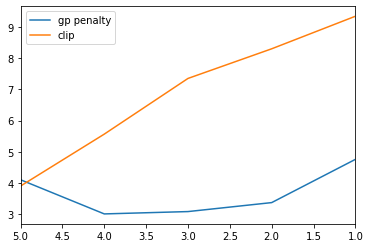